# Time Series
For cores, we are usually only interested in changes in the depth-wise direction. It is therefore reasonable to average values along the perpendicular direction. The tilt correction we applied in chapters 4 and 5 ensures that we are actually averaging over equal depths instead of smearing the depth signal out. 

In principle, we can average by any column in the data frame of the MSI object. The time series will contain the average value for each zone. Let's start with using the laminae from chapter 4 

In [1]:
from user_params import copy_checkpoint
copy_checkpoint(6)

copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\full example.d\MSI_with_images.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\full example.d\MSI_with_images.pickle
copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\ImageClassified.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\ImageClassified.pickle


In [2]:
%matplotlib inline

from maspim import get_project
import user_params

project = get_project(is_MSI=True, path_folder=user_params.path_folder_real_data)

project.require_data_object(tag='with_images')

C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


mis_file: full example.mis
path_folder: C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example
d_folder: full example.d
_distance_pixels: None
_feature_table: Pandas DataFrame with columns [553.5319, 551.5162, 557.2523, tic_window, R, x, y, x_ROI, y_ROI, L, ...], indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...] and shape (17118, 15)

## Depth and age column
Let's also add the depth and age column so that the time series initializer can make use of it

In [3]:
from maspim import AgeModel

# let's quickly set up and add a very basic age model with two data points
age_span = (0, 100)
depth_span = (490, 495)
age_model = AgeModel(depth=depth_span, age=age_span)
project.age_model = age_model
project.depth_span = depth_span

project.add_depth_column()
project.add_age_column()

## Averaging by layers

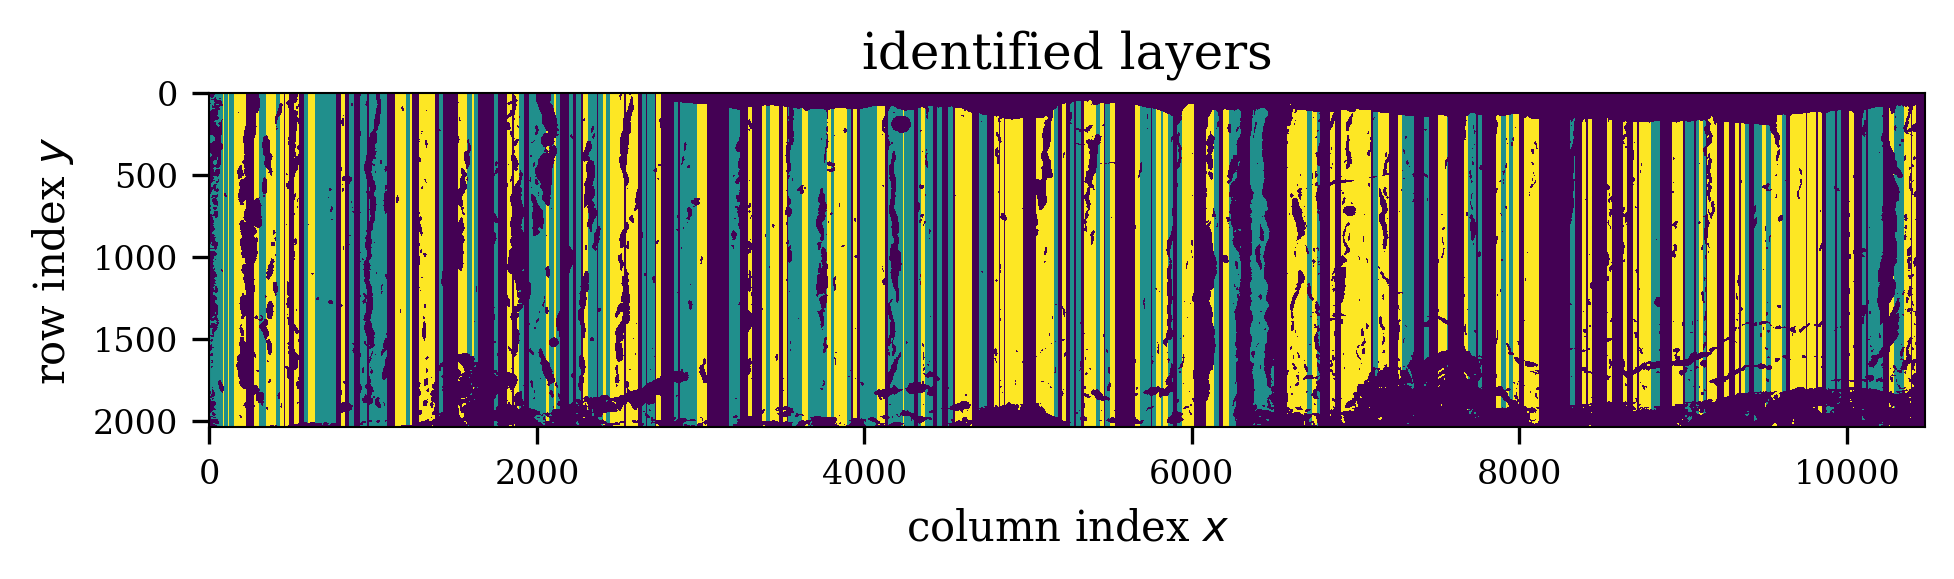

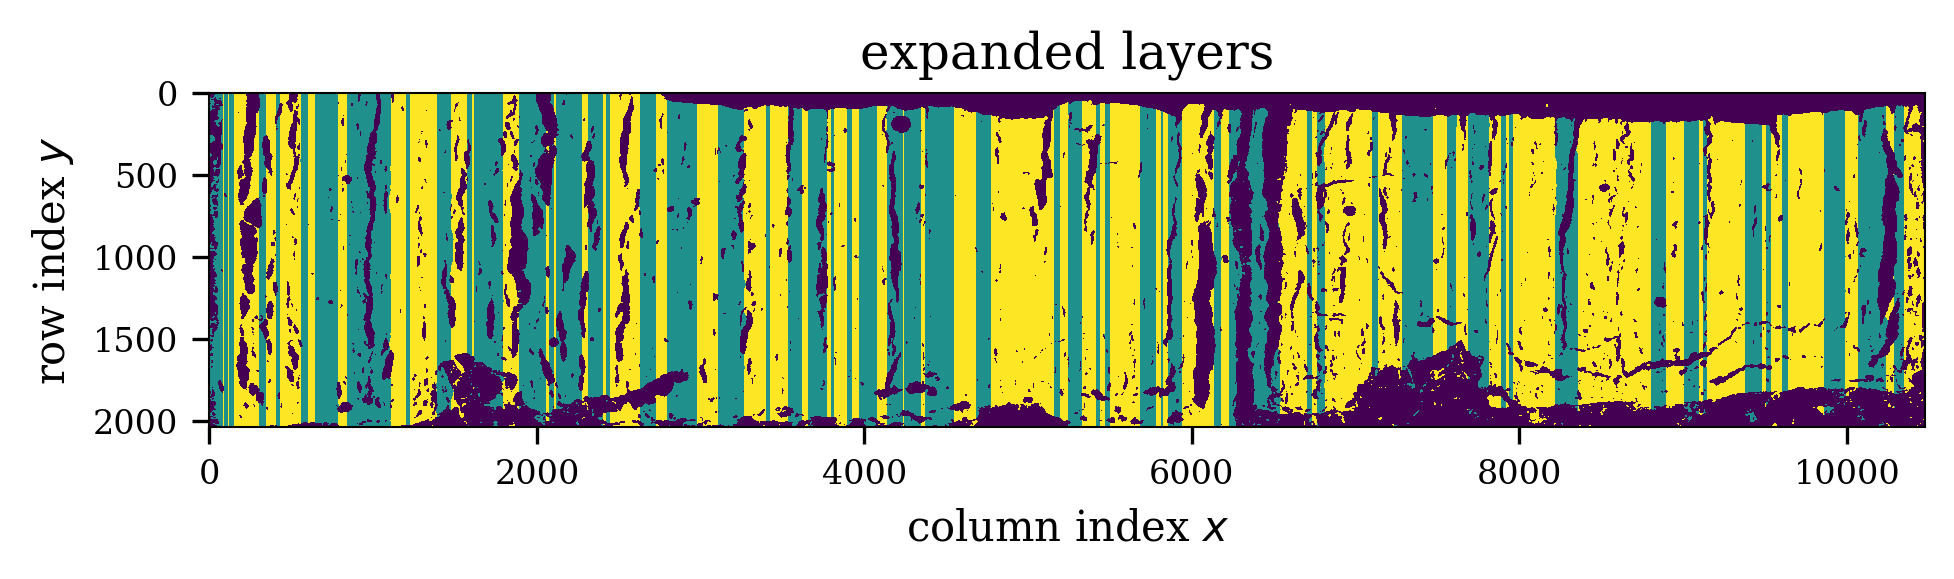

averaging values for zones: 100%|██████████████████████████████████████████████████| 128/128 [00:00<00:00, 2345.51it/s]


In [4]:
# classification_se corresponds to the expanded laminae classification (no gaps between layers)
# classification_s is not expanded
from maspim import plt_cv2_image
import numpy as np
img_classified = project.require_image_classified()
plt_cv2_image(img_classified.get_image_simplified_classification(), cmap='viridis', title='identified layers')
# make the color schemes match (-1 for background, 1 for light and 0 for dark)
img_expanded = np.sign(img_classified.get_image_expanded_laminae())
img_expanded[img_expanded == 0] = -2
img_expanded[img_expanded == -1] = 0
img_expanded[img_expanded == -2] = -1
plt_cv2_image(img_expanded, cmap='viridis', title='expanded layers')

ts_laminae = project.require_time_series(average_by_col='classification_se', tag='laminae', n_successes_required=1, overwrite=True).copy()

This time series is quite unevenly spaced and s

## Averaging by depths

In [5]:
# add column with rounded depths
# keep in mind that our sample points are spaced apart by 100μm
# what happens if you go lower/ higher?
interval_microm = 500
interval_cm = interval_microm / 1e4
project.data_object.feature_table.loc[:, 'rounded_depth'] = interval_cm * np.around(project.data_object.feature_table.loc[:, 'depth'] / interval_cm)

ts_depth = project.require_time_series(average_by_col='rounded_depth', tag='depth', n_successes_required=1, overwrite=True).copy()

averaging values for zones: 100%|██████████████████████████████████████████████████| 101/101 [00:00<00:00, 2140.87it/s]


Let's quickly plot the C37:2 alkenone which should show some variation throughout the seasons

### Quiz
But before that, why could it be useful to correct the TIC (multiple right answers)?

In [6]:
from tasks import chapter6_task1

chapter6_task1.options()
chapter6_task1.ask()

The following options are available (you can enter the number of the answer):
(1) Get more handleable values
(2) Remove variations merely caused by higher sediment input
(3) Remove variations caused by variances in the matrix
(4) This is necessary if you want to calculate contrasts
(5) This keeps the values at a reasonable scale and prevents floating point precision losses


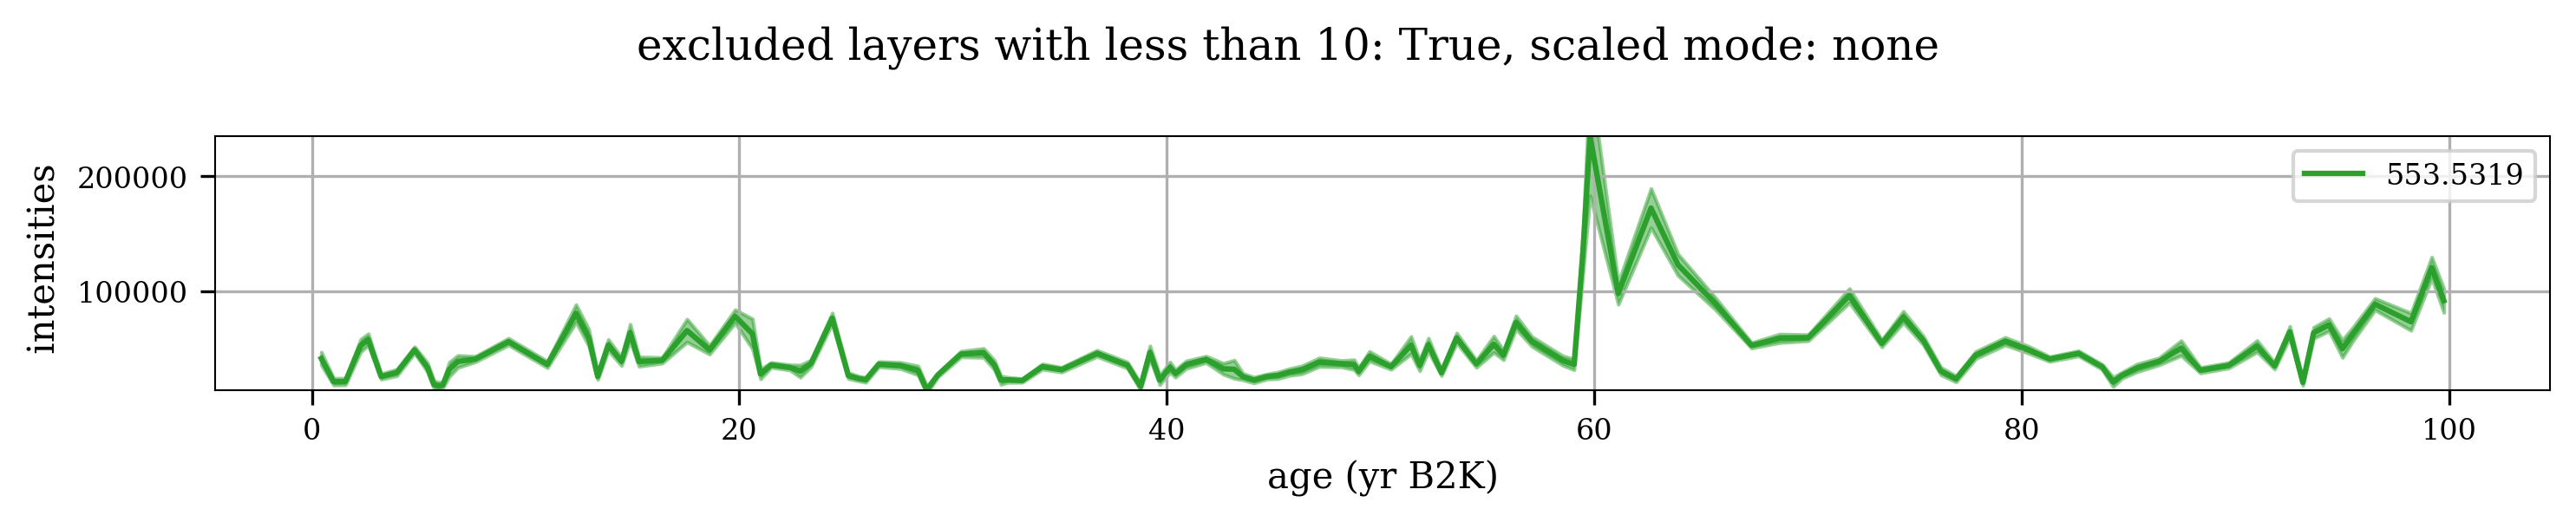

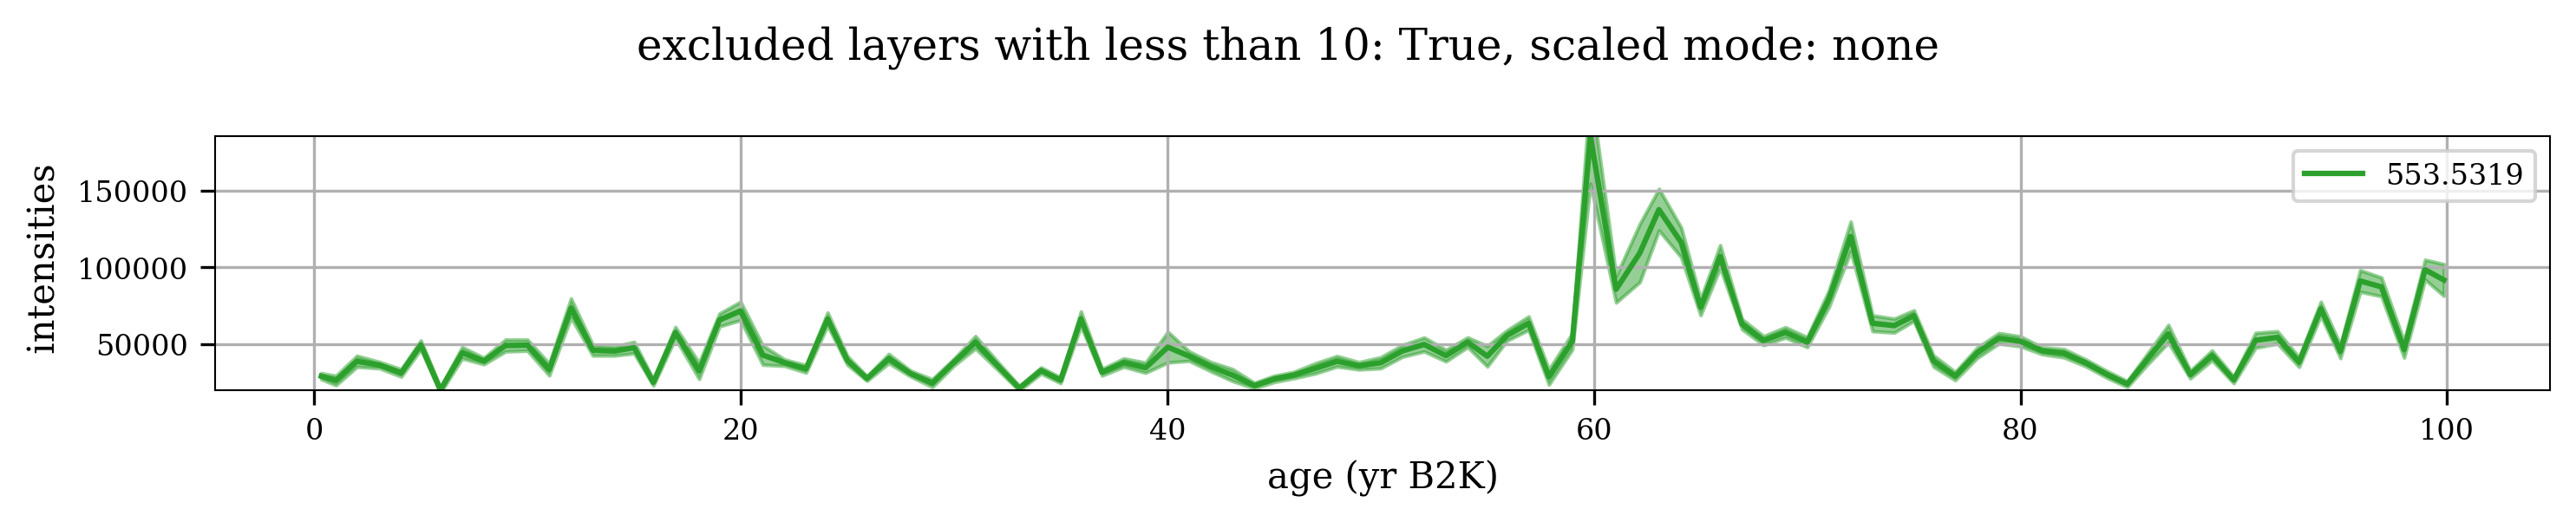

In [7]:
from maspim.res.compound_masses import mC37_2, mC37_3

# increase the number of successful spectra for plotting
ts_laminae.n_successes_required = 10
ts_laminae.plot_comp(mC37_2, norm_mode='none', exclude_layers_low_successes=True, correct_tic=False, contrasts=False)
ts_depth.n_successes_required = 10
ts_depth.plot_comp(mC37_2, norm_mode='none', exclude_layers_low_successes=True, correct_tic=False, contrasts=False)

Judging from the error margins we can resolve time variations on a scale smaller than the laminae. Let's continue with using the depth-averaged time series. 

## Setting proxies
There is support for the UK37 proxy but not for the error estimation yet. As a workaround we can add the UK37 values to the time series

In [8]:
project.set_UK37(method_SST='prahl', n_successes_required=1)
project.time_series.errors
df = project.time_series.feature_table
err = project.time_series._feature_table_standard_errors
df.loc[:, 'ratio'] = project.uk37_proxy.feature_table.ratio
err.loc[:, 'ratio'] = project.uk37_proxy.get_std_err_ratio()

project.time_series.successes['ratio'] = project.uk37_proxy.successes.ratio

Let's see how the UK values behave in relation to it's constituents 

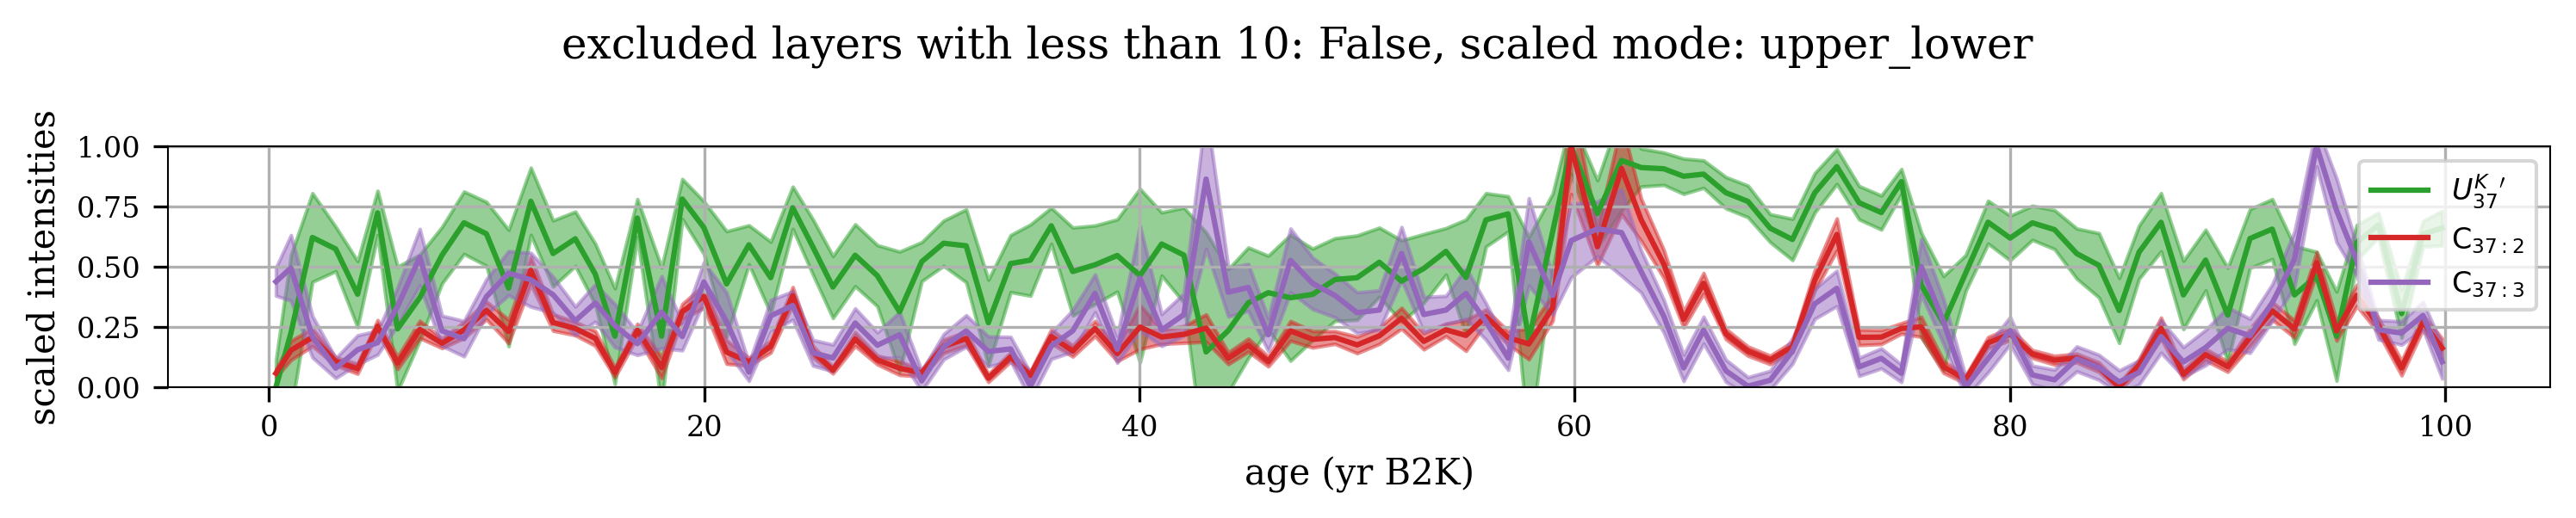

In [9]:
project.time_series.plot_comp(
    ['ratio', mC37_2, mC37_3], 
    correct_tic=[False, True, True], 
    norm_mode='upper_lower', 
    contrasts=False, 
    names=[r'${U_{37}^K}^\prime$', r'$\mathrm{C}_{37:2}$', r'$\mathrm{C}_{37:3}$']
)

There are hundreds of questions we could ask (correlation of UK values and grayscale, grayscale and X-ray, Fe/Si and grayscale, ...) but we will end our analysis here. 